# Dallas Animal Shelter 2019

Data is from 2 separate Dallas Animal Shelter records: one contains data from October 2018-September 2019 and the other from October 2019-March 2020.

This analysis will simply look year 2019, taking all data within 2019 from both datasets into one.

## Hypothesis Testing  

**Null Hypothesis**: cats and dogs have similar outcomes when encountered with similar intake type and condition.

**Alternative Hypothesis**: the intake condition and type of cats affect their outcome less than dogs.


## Load in data

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

plt.style.use('ggplot')

%matplotlib inline

# description of fields: https://www.dallasopendata.com/City-Services/Animals-Inventory/qgg6-h4bd
# https://gis.dallascityhall.com/documents/StaticMaps/Council/2013_Council_PDFs/2013_CouncilDistrictAllA.pdf

In [2]:
fy_2020 = pd.read_csv('FY2020_Dallas_Animal_Shelter_Data.csv', low_memory=False)
fy_2019 = pd.read_csv('FY_2019_Dallas_Animal_Shelter_Data.csv', low_memory=False)

_Check months to make sure it has all of 2019 months that are missing in the 2020 dataset._

In [3]:
fy_2020['Month'].value_counts()

OCT.2019    3998
JAN.2020    3658
NOV.2019    3526
DEC.2019    3363
FEB.2020    3127
MAR.2020    2575
Name: Month, dtype: int64

In [4]:
fy_2019['Month'].value_counts()

JUN.2019    4953
MAY.2019    4658
JUL.2019    4539
AUG.2019    4239
SEP.2019    3928
JAN.2019    3843
APR.2019    3759
MAR.2019    3681
DEC.2018    3523
OCT.2018    3219
FEB.2019    3093
NOV.2018    2974
Name: Month, dtype: int64

In [5]:
print(fy_2020.shape)
print(fy_2019.shape)

(20247, 34)
(46409, 34)


_Checking to make sure the column names match so they can be merged correctly._

In [6]:
print('FY2020 Column Names: ', fy_2020.columns)
print('FY2019 Column Names: ', fy_2019.columns)

FY2020 Column Names:  Index(['Animal Id', 'Animal Type', 'Animal Breed', 'Kennel Number',
       'Kennel Status', 'Tag Type', 'Activity Number', 'Activity Sequence',
       'Source Id', 'Census Tract', 'Council District', 'Intake Type',
       'Intake Subtype', 'Intake Total', 'Reason', 'Staff Id', 'Intake Date',
       'Intake Time', 'Due Out', 'Intake Condition', 'Hold Request',
       'Outcome Type', 'Outcome Subtype', 'Outcome Date', 'Outcome Time',
       'Receipt Number', 'Impound Number', 'Service Request Number',
       'Outcome Condition', 'Chip Status', 'Animal Origin',
       'Additional Information', 'Month', 'Year'],
      dtype='object')
FY2019 Column Names:  Index(['Animal_Id', 'Animal_Type', 'Animal_Breed', 'Kennel_Number',
       'Kennel_Status', 'Tag_Type', 'Activity_Number', 'Activity_Sequence',
       'Source_Id', 'Census_Tract', 'Council_District', 'Intake_Type',
       'Intake_Subtype', 'Intake_Total', 'Reason', 'Staff_Id', 'Intake_Date',
       'Intake_Time', 'Du

_It looks like 2019 dataset columns have an underscore instead spaces. Let's change it all to the standard python snake case with underscore as spaces._

In [7]:
fy_2020.columns = fy_2020.columns.str.strip().str.lower().str.replace(' ', '_')
fy_2019.columns = fy_2019.columns.str.strip().str.lower()

## Time and Date

_Checking the date and time columns to make sure the formats are similar because it will need to be combined later on._

In [8]:
fy_2020[['intake_date', 'intake_time', 'outcome_date', 'outcome_time']].head()

,intake_date,intake_time,outcome_date,outcome_time
0,11/8/19,15:48:00,11/9/19,11:31:00
1,11/10/19,14:18:00,11/10/19,0:00:00
2,10/3/19,11:08:00,10/3/19,13:36:00
3,10/11/19,9:55:00,10/15/19,17:35:00
4,11/8/19,11:55:00,11/9/19,12:57:00


_The 2020 date and time column looks good._

In [9]:
fy_2019[['intake_date', 'intake_time', 'outcome_date', 'outcome_time']].head()

,intake_date,intake_time,outcome_date,outcome_time
0,03/03/2019 12:00:00 AM,16:00:00,03/03/2019 12:00:00 AM,16:03:00
1,10/03/2018 12:00:00 AM,22:04:00,10/12/2018 12:00:00 AM,12:21:00
2,01/26/2019 12:00:00 AM,13:21:00,01/26/2019 12:00:00 AM,17:06:00
3,06/08/2019 12:00:00 AM,14:29:00,06/08/2019 12:00:00 AM,14:29:00
4,12/31/2018 12:00:00 AM,12:51:00,12/31/2018 12:00:00 AM,13:12:00


_The time inside the date column is unnecessary and will only cause trouble later on. It will be stripped._

In [10]:
#The intake_date column does not contain any null values and the outcome_date column contains 6.
print(fy_2019[fy_2019['intake_date'].str.contains('12:00:00 AM')].shape)
print(fy_2019[fy_2019['outcome_date'].isnull()].shape)

(46409, 34)
(6, 34)


In [11]:
fy_2019['intake_date'] = fy_2019['intake_date'].str.replace(' 12:00:00 AM', '')
fy_2019['outcome_date'] = fy_2019['outcome_date'].str.replace(' 12:00:00 AM', '')
print(fy_2019[['intake_date','outcome_date']].head(1))

  intake_date outcome_date
0  03/03/2019   03/03/2019


_In order to exact information such as day, month, and so on, the datetime columns need to be converted to DateTime objects._

In [12]:
fy_2019['intake_datetime'] = fy_2019['intake_date'] + ' ' + fy_2019['intake_time']
fy_2019['outcome_datetime'] = fy_2019['outcome_date'] + ' ' + fy_2019['outcome_time']
fy_2019['intake_datetime'] = pd.to_datetime(fy_2019['intake_datetime'], format='%m/%d/%Y %H:%M:%S')
fy_2019['outcome_datetime'] = pd.to_datetime(fy_2019['outcome_datetime'], format='%m/%d/%Y %H:%M:%S')

fy_2020['intake_datetime'] = fy_2020['intake_date'] + ' ' + fy_2020['intake_time']
fy_2020['outcome_datetime'] = fy_2020['outcome_date'] + ' ' + fy_2020['outcome_time']
fy_2020['intake_datetime'] = pd.to_datetime(fy_2020['intake_datetime'], format='%m/%d/%y %H:%M:%S')
fy_2020['outcome_datetime'] = pd.to_datetime(fy_2020['outcome_datetime'], format='%m/%d/%y %H:%M:%S')

In [13]:
print(fy_2019[['intake_datetime', 'outcome_datetime']].head(1))
print('\n')
print(fy_2020[['intake_datetime', 'outcome_datetime']].head(1))

      intake_datetime    outcome_datetime
0 2019-03-03 16:00:00 2019-03-03 16:03:00


      intake_datetime    outcome_datetime
0 2019-11-08 15:48:00 2019-11-09 11:31:00


## Merge datasets

In [14]:
original_df = pd.concat([fy_2020, fy_2019], axis=0, join='outer')
original_df.head()

,animal_id,animal_type,animal_breed,kennel_number,kennel_status,tag_type,activity_number,activity_sequence,source_id,census_tract,council_district,intake_type,intake_subtype,intake_total,reason,staff_id,intake_date,intake_time,due_out,intake_condition,hold_request,outcome_type,outcome_subtype,outcome_date,outcome_time,receipt_number,impound_number,service_request_number,outcome_condition,chip_status,animal_origin,additional_information,month,year,intake_datetime,outcome_datetime
0,A0144701,DOG,HAVANESE,VT 12,IMPOUNDED,NaN,NaN,1,P0098773,6301,4,OWNER SURRENDER,GENERAL,1,PERSNLISSU,CDM,11/8/19,15:48:00,11/14/19,APP SICK,NaN,RETURNED TO OWNER,WALK IN,11/9/19,11:31:00,R19-558731,K19-486742,NaN,APP SICK,SCAN CHIP,OVER THE COUNTER,RETURNED TO OWNER,NOV.2019,FY2020,2019-11-08 15:48:00,2019-11-09 11:31:00
1,A0442587,DOG,TERRIER MIX,FREEZER,IMPOUNDED,NaN,NaN,1,P0492284,7102,2,OWNER SURRENDER,DEAD ON ARRIVAL,1,OTHRINTAKS,CDM,11/10/19,14:18:00,11/10/19,DEAD,NaN,DEAD ON ARRIVAL,DISPOSAL,11/10/19,0:00:00,NaN,K19-486954,NaN,DEAD,SCAN CHIP,OVER THE COUNTER,NaN,NOV.2019,FY2020,2019-11-10 14:18:00,2019-11-10 00:00:00
2,A0458972,DOG,CATAHOULA,RECEIVING,UNAVAILABLE,NaN,A19-195601,1,P9991718,4600,1,STRAY,AT LARGE,1,OTHER,MG1718,10/3/19,11:08:00,10/3/19,TREATABLE REHABILITABLE NON-CONTAGIOUS,NaN,RETURNED TO OWNER,FIELD,10/3/19,13:36:00,NaN,K19-482022,NaN,TREATABLE REHABILITABLE NON-CONTAGIOUS,SCAN NO CHIP,SWEEP,NaN,OCT.2019,FY2020,2019-10-03 11:08:00,2019-10-03 13:36:00
3,A0525642,DOG,GERM SHEPHERD,INJD 001,IMPOUNDED,NaN,A19-196573,1,P0903792,16605,8,OWNER SURRENDER,GENERAL,1,OTHER,RA 1549,10/11/19,9:55:00,10/17/19,TREATABLE REHABILITABLE NON-CONTAGIOUS,EMERGENCY RESCUE,TRANSFER,MEDICAL-CONTAGIOUS,10/15/19,17:35:00,NaN,K19-483073,NaN,TREATABLE REHABILITABLE NON-CONTAGIOUS,SCAN CHIP,SWEEP,TAGGED,OCT.2019,FY2020,2019-10-11 09:55:00,2019-10-15 17:35:00
4,A0565586,DOG,SILKY TERRIER,LFD 119,UNAVAILABLE,NaN,NaN,1,P0890077,6900,1,STRAY,AT LARGE,1,OTHRINTAKS,JR,11/8/19,11:55:00,11/14/19,APP WNL,RESCU ONLY,RETURNED TO OWNER,WALK IN,11/9/19,12:57:00,R19-558750,K19-486694,NaN,APP WNL,SCAN CHIP,OVER THE COUNTER,RETURNED TO OWNER,NOV.2019,FY2020,2019-11-08 11:55:00,2019-11-09 12:57:00


_Looked at value counts of many columns to determine which ones are necessary._

## Create dataframe with necessary columns

In [15]:
dallas = original_df[['animal_id', 'animal_type', 'animal_breed', 'council_district', 'intake_type', 'intake_subtype', 
                      'intake_condition', 'intake_datetime', 'reason', 'due_out', 'outcome_type', 
                      'outcome_subtype', 'outcome_condition', 'outcome_datetime']]

In [16]:
dallas.head()

,animal_id,animal_type,animal_breed,council_district,intake_type,intake_subtype,intake_condition,intake_datetime,reason,due_out,outcome_type,outcome_subtype,outcome_condition,outcome_datetime
0,A0144701,DOG,HAVANESE,4,OWNER SURRENDER,GENERAL,APP SICK,2019-11-08 15:48:00,PERSNLISSU,11/14/19,RETURNED TO OWNER,WALK IN,APP SICK,2019-11-09 11:31:00
1,A0442587,DOG,TERRIER MIX,2,OWNER SURRENDER,DEAD ON ARRIVAL,DEAD,2019-11-10 14:18:00,OTHRINTAKS,11/10/19,DEAD ON ARRIVAL,DISPOSAL,DEAD,2019-11-10 00:00:00
2,A0458972,DOG,CATAHOULA,1,STRAY,AT LARGE,TREATABLE REHABILITABLE NON-CONTAGIOUS,2019-10-03 11:08:00,OTHER,10/3/19,RETURNED TO OWNER,FIELD,TREATABLE REHABILITABLE NON-CONTAGIOUS,2019-10-03 13:36:00
3,A0525642,DOG,GERM SHEPHERD,8,OWNER SURRENDER,GENERAL,TREATABLE REHABILITABLE NON-CONTAGIOUS,2019-10-11 09:55:00,OTHER,10/17/19,TRANSFER,MEDICAL-CONTAGIOUS,TREATABLE REHABILITABLE NON-CONTAGIOUS,2019-10-15 17:35:00
4,A0565586,DOG,SILKY TERRIER,1,STRAY,AT LARGE,APP WNL,2019-11-08 11:55:00,OTHRINTAKS,11/14/19,RETURNED TO OWNER,WALK IN,APP WNL,2019-11-09 12:57:00


## Missing values and strange datatypes

In [17]:
dallas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66656 entries, 0 to 46408
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   animal_id          66656 non-null  object        
 1   animal_type        66656 non-null  object        
 2   animal_breed       66656 non-null  object        
 3   council_district   63398 non-null  object        
 4   intake_type        66656 non-null  object        
 5   intake_subtype     66656 non-null  object        
 6   intake_condition   66656 non-null  object        
 7   intake_datetime    66656 non-null  datetime64[ns]
 8   reason             45300 non-null  object        
 9   due_out            66656 non-null  object        
 10  outcome_type       66656 non-null  object        
 11  outcome_subtype    66656 non-null  object        
 12  outcome_condition  63930 non-null  object        
 13  outcome_datetime   66331 non-null  datetime64[ns]
dtypes: dat

_Every column seems to have minimal amounts of missing values except for the 'reason' column. We will check the values within that column and see if it is important._

In [18]:
dallas['reason'].unique()

array(['PERSNLISSU', 'OTHRINTAKS', 'OTHER', 'MEDICAL', 'FINANCIAL',
       'BEHAVIOR', 'NOTRIGHTFT', nan, 'HOUSING', 'TOO OLD', 'ILL',
       'EUTHANASIA ILL', 'LANDLORD', 'COST', 'DEAD ON ARRIVAL',
       'QUARANTINE', 'OWNER DIED', 'NO HOME', 'AGGRESSIVE - ANIMAL',
       'MOVE', 'OTHER PET', 'ALLERGIC', 'VOCAL', 'RESPONSIBLE',
       'MOVE APT', 'NO TIME', 'NO YARD', 'OWNER PROBLEM',
       'DESTRUCTIVE OUTSIDE', 'BLIND', 'AGGRESSIVE - PEOPLE', 'ESCAPES',
       'BITES', 'FOSTER', 'DESTRUCTIVE AT HOME', 'CAUTIONCAT', 'HYPER',
       'INJURED', 'ABANDON', 'CHILD PROBLEM', 'ATTENTION', 'TRAVEL',
       'DISOBIDIEN', 'FOUND ANIM', 'NEW BABY', 'TOO BIG', 'NOFRIENDLY',
       'JUMPS UP', 'TOO MANY', 'GIFT', 'HOUSE SOIL', 'RETURN', 'AFRAID',
       'WONT ALLOW', 'UNKNOWN', 'PET LIMITS', 'STRAY', 'FENCE',
       'CONFISCATE', 'WILDLIFE', 'WANTS OUT', 'KILLED ANOTHER ANIMAL',
       'EUTHANASIA OTHER', 'TOO YOUNG', 'CHASES PEOPLE', 'WRONG SEX',
       'EUTHANASIA OLD', 'EUTHANASIA BEHAV', '

_Most of the reasons are similar but different and very specific. It will not be too useful for this hypothesis since we are looking at simply the intake condition and the general intake type. Checking out the value counts, they are also mainly in the 'other' category will small amounts in the other categories. We can safely drop the 'reason' column entirely._

In [19]:
pd.options.mode.chained_assignment = None

dallas.drop(['reason'], axis=1, inplace=True)

In [20]:
# check to make sure 'reason' column got dropped
dallas.columns

Index(['animal_id', 'animal_type', 'animal_breed', 'council_district',
       'intake_type', 'intake_subtype', 'intake_condition', 'intake_datetime',
       'due_out', 'outcome_type', 'outcome_subtype', 'outcome_condition',
       'outcome_datetime'],
      dtype='object')

_The rest of the columns do not contain a huge amount of missing values that would affect the testing. Therefore, we will drop all rows with null values._

In [21]:
dallas.dropna(axis=0, inplace=True)

In [22]:
dallas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62860 entries, 0 to 46408
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   animal_id          62860 non-null  object        
 1   animal_type        62860 non-null  object        
 2   animal_breed       62860 non-null  object        
 3   council_district   62860 non-null  object        
 4   intake_type        62860 non-null  object        
 5   intake_subtype     62860 non-null  object        
 6   intake_condition   62860 non-null  object        
 7   intake_datetime    62860 non-null  datetime64[ns]
 8   due_out            62860 non-null  object        
 9   outcome_type       62860 non-null  object        
 10  outcome_subtype    62860 non-null  object        
 11  outcome_condition  62860 non-null  object        
 12  outcome_datetime   62860 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(11)
memory usage: 6.7+ MB


In [23]:
dallas['council_district'].value_counts(dropna=False)

6.0     9277
4.0     6000
8.0     5540
5.0     4893
6       4756
7.0     3938
1.0     3809
3.0     3195
2.0     2357
4       2224
8       2041
5       1894
9.0     1565
7       1432
1       1299
3       1248
10.0    1134
14.0     831
12.0     823
11.0     802
13.0     782
2        767
9        651
10       396
13       341
14       318
11       313
12       220
0          7
AS         4
21.0       2
0.0        1
Name: council_district, dtype: int64

_The council district is a bit messy. It has multiple datatypes but are basically the same number. The numbers will have to be changed to integer type and drop the random string value.  
Also, looking at the Dallas district map, there are no districts 0 or 21. Those rows will also be dropped._

In [24]:
#Taking only rows where council_district is not the string value thus dropping those rows.
dallas = dallas[(dallas['council_district'] != 'AS')]

In [25]:
#Mapping the int() function on all values to change the datatype
dallas['council_district'] = dallas['council_district'].map(int)

In [26]:
#Dropping all the district 0's and 21's
dallas.drop(dallas[dallas['council_district'] == 0].index, inplace=True)
dallas.drop(dallas[dallas['council_district'] == 21].index, inplace=True)

In [27]:
dallas['council_district'].value_counts().sort_index()

1      5107
2      3123
3      4442
4      8224
5      6787
6     14032
7      5370
8      7578
9      2216
10     1530
11     1115
12     1043
13     1123
14     1149
Name: council_district, dtype: int64

## Column Values

In [28]:
dallas.head()

,animal_id,animal_type,animal_breed,council_district,intake_type,intake_subtype,intake_condition,intake_datetime,due_out,outcome_type,outcome_subtype,outcome_condition,outcome_datetime
0,A0144701,DOG,HAVANESE,4,OWNER SURRENDER,GENERAL,APP SICK,2019-11-08 15:48:00,11/14/19,RETURNED TO OWNER,WALK IN,APP SICK,2019-11-09 11:31:00
1,A0442587,DOG,TERRIER MIX,2,OWNER SURRENDER,DEAD ON ARRIVAL,DEAD,2019-11-10 14:18:00,11/10/19,DEAD ON ARRIVAL,DISPOSAL,DEAD,2019-11-10 00:00:00
2,A0458972,DOG,CATAHOULA,1,STRAY,AT LARGE,TREATABLE REHABILITABLE NON-CONTAGIOUS,2019-10-03 11:08:00,10/3/19,RETURNED TO OWNER,FIELD,TREATABLE REHABILITABLE NON-CONTAGIOUS,2019-10-03 13:36:00
3,A0525642,DOG,GERM SHEPHERD,8,OWNER SURRENDER,GENERAL,TREATABLE REHABILITABLE NON-CONTAGIOUS,2019-10-11 09:55:00,10/17/19,TRANSFER,MEDICAL-CONTAGIOUS,TREATABLE REHABILITABLE NON-CONTAGIOUS,2019-10-15 17:35:00
4,A0565586,DOG,SILKY TERRIER,1,STRAY,AT LARGE,APP WNL,2019-11-08 11:55:00,11/14/19,RETURNED TO OWNER,WALK IN,APP WNL,2019-11-09 12:57:00


In [29]:
dallas.shape

(62839, 13)

_Check the animal ids for any duplicates_

In [30]:
dallas['animal_id'].nunique()

49276

In [31]:
(dallas['animal_id'].value_counts()).head(8750)

A1055371    17
A1070239    15
A1020975    14
A1084959    11
A1037818    10
            ..
A1092900     2
A1070474     2
A1074145     2
A1046759     2
A1047377     1
Name: animal_id, Length: 8750, dtype: int64

In [32]:
dallas.drop_duplicates('animal_id', keep='last', inplace=True)

In [33]:
#Check if any animal ids still have multiple counts.
(dallas['animal_id'].value_counts() > 1).any()

False

In [34]:
dallas['animal_type'].value_counts()

DOG          35847
CAT          11334
WILDLIFE      1625
BIRD           442
LIVESTOCK       28
Name: animal_type, dtype: int64

_For the hypothesis, the only data we need are cats and dogs. The dataframe will be filtered to have only rows where the animal type is either cats or dogs._

In [35]:
dallas = dallas[(dallas['animal_type'] == 'CAT') | (dallas['animal_type'] == 'DOG')]
dallas['animal_type'].value_counts()

DOG    35847
CAT    11334
Name: animal_type, dtype: int64

In [36]:
print('Intake Type: ', list(dallas['intake_type'].unique()))
print('\n')
print('Intake Subtype: ', list(dallas['intake_subtype'].unique()))
print('\n')
print('Intake Condition: ', list(dallas['intake_condition'].unique()))
print('\n')
print('Outcome Type: ', list(dallas['outcome_type'].unique()))
print('\n')
print('Outcome Subtype: ', list(dallas['outcome_subtype'].unique()))
print('\n')
print('Outcome Condition: ', list(dallas['outcome_condition'].unique()))

Intake Type:  ['OWNER SURRENDER', 'STRAY', 'CONFISCATED', 'TRANSFER', 'FOSTER', 'TREATMENT', 'KEEPSAFE', 'DISPOS REQ']


Intake Subtype:  ['GENERAL', 'DEAD ON ARRIVAL', 'AT LARGE', 'RETURN30', 'EUTHANASIA REQUESTED', 'CONFINED', 'QUARANTINE', 'OTHER', 'KEEP SAFE', 'QUARANTINE DEAD ON ARRIVAL', 'SURGERY', 'RETURN', 'SAC DEAD ON ARRIVAL', 'APPOINT', 'HEART WORM', 'CRUELTY', 'DIED', 'TREATMENT', 'DANGEROUS', 'TRAP NEUTER RETURN', 'FOR ADOPT', 'EVICTION', 'KEEP SAFE DEAD ON ARRIVAL', 'FIELD', 'OWN ARREST', 'SX POST OP', 'OTC', 'MISSING', 'AGG OPPS', 'ALUMNI', 'OWN HOSPIT', 'FOLLOWUP', 'SAC', 'ARC', 'POSSIBLY OWNED', 'TRAP PROGRAM', 'SPCA TEXAS', 'CRUELT DEAD ON ARRIVAL', 'STRAY']


Intake Condition:  ['APP SICK', 'DEAD', 'TREATABLE REHABILITABLE NON-CONTAGIOUS', 'APP WNL', 'UNHEALTHY UNTREATABLE NON-CONTAGIOUS', 'CRITICAL', 'APP INJ', 'UNKNOWN', 'UNHEALTHY UNTREATABLE CONTAGIOUS', 'TREATABLE MANAGEABLE NON-CONTAGIOUS', 'TREATABLE MANAGEABLE CONTAGIOUS', 'HEALTHY', 'UNDERAGE', 'TREATABLE RE

In [37]:
dallas['outcome_type'].value_counts()

ADOPTION             15850
RETURNED TO OWNER    13545
TRANSFER              9140
EUTHANIZED            5556
FOSTER                1654
DIED                   497
DEAD ON ARRIVAL        465
TREATMENT              444
MISSING                 27
DISPOSAL                 3
Name: outcome_type, dtype: int64

In [38]:
dallas.groupby(['outcome_type', 'outcome_subtype']).count()['intake_subtype'].head(50)

outcome_type       outcome_subtype      
ADOPTION           AD TV                        2
                   BY FOSTER                  128
                   EAC                       1346
                   EAC OFFSIT                   2
                   EVENT                      109
                   IN FOSTER                  279
                   OFFSITE                    320
                   PAY PENDNG                   7
                   PHONE                        1
                   PROMOTION                 1308
                   REFERRAL                   146
                   RESCUE GROUP                 1
                   TELEADOPT                   16
                   WALK IN                  11885
                   WEB                          6
                   WESTMORELD                 294
DEAD ON ARRIVAL    DISPOSAL                   356
                   HOLD                        72
                   RETURN                       5
         

In [39]:
dallas.groupby(['intake_type', 'intake_subtype']).count()['outcome_type'].head(50)

intake_type      intake_subtype            
CONFISCATED      CRUELT DEAD ON ARRIVAL           18
                 CRUELTY                         113
                 DANGEROUS                        25
                 EVICTION                         63
                 KEEP SAFE                       646
                 KEEP SAFE DEAD ON ARRIVAL        17
                 QUARANTINE                     1024
                 QUARANTINE DEAD ON ARRIVAL       83
                 SAC                              10
                 SAC DEAD ON ARRIVAL               2
DISPOS REQ       ARC                               2
                 FIELD                             2
FOSTER           APPOINT                           1
                 DIED                             79
                 FOR ADOPT                         2
                 GENERAL                         787
                 MISSING                           5
                 QUARANTINE                        7
  

_Looking at the outcome type and the outcome subtype, it seems the outcome subtype is not really necessary. The main goal is to see if they make it to adoption stage, but it doesn't matter who does the adoption. The outcome subtype column will be dropped._

In [40]:
dallas.drop('outcome_subtype', axis=1, inplace=True)

In [41]:
dallas.head(1)

,animal_id,animal_type,animal_breed,council_district,intake_type,intake_subtype,intake_condition,intake_datetime,due_out,outcome_type,outcome_condition,outcome_datetime
0,A0144701,DOG,HAVANESE,4,OWNER SURRENDER,GENERAL,APP SICK,2019-11-08 15:48:00,11/14/19,RETURNED TO OWNER,APP SICK,2019-11-09 11:31:00


# Exploratory Data Analysis (EDA)

In [42]:
dallas.head()

,animal_id,animal_type,animal_breed,council_district,intake_type,intake_subtype,intake_condition,intake_datetime,due_out,outcome_type,outcome_condition,outcome_datetime
0,A0144701,DOG,HAVANESE,4,OWNER SURRENDER,GENERAL,APP SICK,2019-11-08 15:48:00,11/14/19,RETURNED TO OWNER,APP SICK,2019-11-09 11:31:00
1,A0442587,DOG,TERRIER MIX,2,OWNER SURRENDER,DEAD ON ARRIVAL,DEAD,2019-11-10 14:18:00,11/10/19,DEAD ON ARRIVAL,DEAD,2019-11-10 00:00:00
2,A0458972,DOG,CATAHOULA,1,STRAY,AT LARGE,TREATABLE REHABILITABLE NON-CONTAGIOUS,2019-10-03 11:08:00,10/3/19,RETURNED TO OWNER,TREATABLE REHABILITABLE NON-CONTAGIOUS,2019-10-03 13:36:00
3,A0525642,DOG,GERM SHEPHERD,8,OWNER SURRENDER,GENERAL,TREATABLE REHABILITABLE NON-CONTAGIOUS,2019-10-11 09:55:00,10/17/19,TRANSFER,TREATABLE REHABILITABLE NON-CONTAGIOUS,2019-10-15 17:35:00
4,A0565586,DOG,SILKY TERRIER,1,STRAY,AT LARGE,APP WNL,2019-11-08 11:55:00,11/14/19,RETURNED TO OWNER,APP WNL,2019-11-09 12:57:00


In [43]:
cats = dallas[dallas['animal_type'] == 'CAT']
dogs = dallas[dallas['animal_type'] == 'DOG']

## Percentages

cats:
- each_intake_type/total_intake_type
- count per month intakes (intake_datetime.dt.month)
- each_outcome_type/total_outcome_type
- count of month outcomes  
- type of intake and the outcome

dogs:
- each_intake_type/total_intake_type
- count per month intakes (intake_datetime.dt.month)
- each_outcome_type/total_outcome_type
- count of month outcomes
- type of intake and the outcome

## Plots and Graphs

_Plotting helper functions_

In [154]:
def autolabel(bar_graph, ax):
    for bar in bar_graph:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

def bar_count(ax, cat_col, dog_col, width=0.35):
    axes_labels = cat_col.index
    x = np.arange(len(axes_labels))
    cat = ax.bar(x - width/2, cat_col, width, label='Cats', color='tomato')
    dog = ax.bar(x + width/2, dog_col, width, label='Dogs', color='lightseagreen')
    ax.set_ylabel('Counts')
    ax.set_title(f'Count of {cat_col.name}: Cats vs Dogs')
    ax.set_xticks(x)
    ax.set_xticklabels(axes_labels, rotation=45)
    ax.legend(loc='upper center')
    autolabel(cat, ax)
    autolabel(dog, ax)
    
def bar_percent(ax, cat_col, dog_col, width=0.35):
    cats_intake = cat_col.values
    cats_percent = ((cats_intake / cats_intake.sum()) * 100).round()
    dogs_intake = dog_col.values
    dogs_percent = ((dogs_intake / dogs_intake.sum()) * 100).round()
    
    axes_labels = cat_col.index
    x = np.arange(len(axes_labels))
    cat = ax.bar(x - width/2, cats_percent, width, label='Cats', color='tomato')
    dog = ax.bar(x + width/2, dogs_percent, width, label='Dogs', color='lightseagreen')
    ax.set_ylabel('Counts')
    ax.set_title(f'Percentage of {cat_col.name}: Cats vs Dogs')
    ax.set_xticks(x)
    ax.set_xticklabels(axes_labels, rotation=45)
    ax.legend(loc='upper center')
    autolabel(cat, ax)
    autolabel(dog, ax)

### Counts of Cats and Dogs per Month

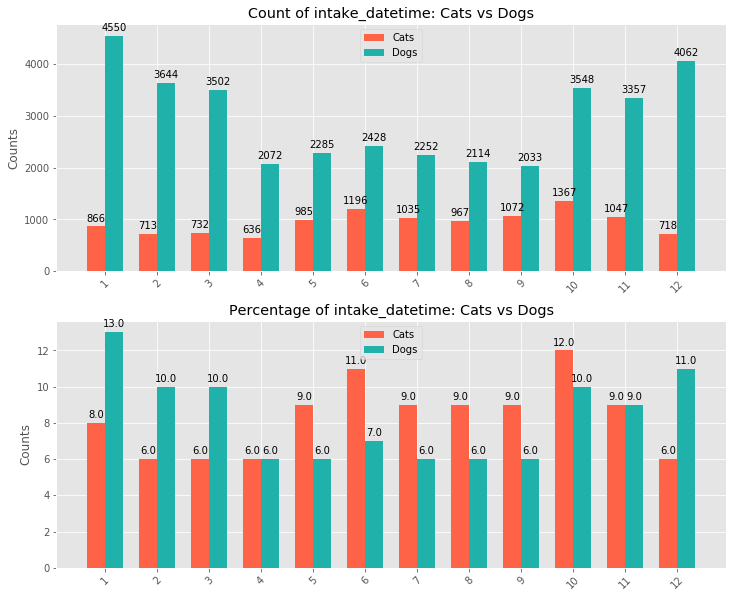

In [155]:
fig, axes = plt.subplots(2,1,figsize=(12,10))

bar_count(axes[0], cats['intake_datetime'].dt.month.value_counts().sort_index(), dogs['intake_datetime'].dt.month.value_counts().sort_index())
bar_percent(axes[1], cats['intake_datetime'].dt.month.value_counts().sort_index(), dogs['intake_datetime'].dt.month.value_counts().sort_index())

### Count/Percentage of Intake Type

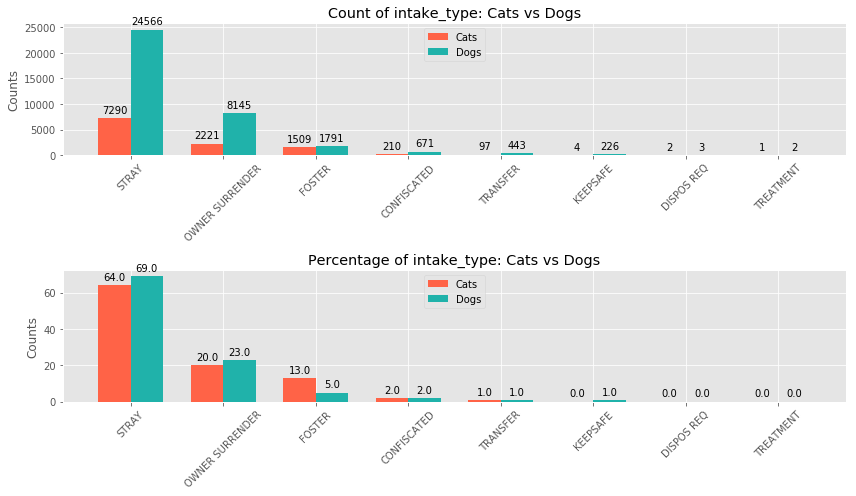

In [156]:
fig, axes = plt.subplots(2,1, figsize=(12,7))

bar_count(axes[0], cats['intake_type'].value_counts(), dogs['intake_type'].value_counts())
bar_percent(axes[1], cats['intake_type'].value_counts(), dogs['intake_type'].value_counts())

plt.tight_layout()

### Count/Percentage of Outcome Type

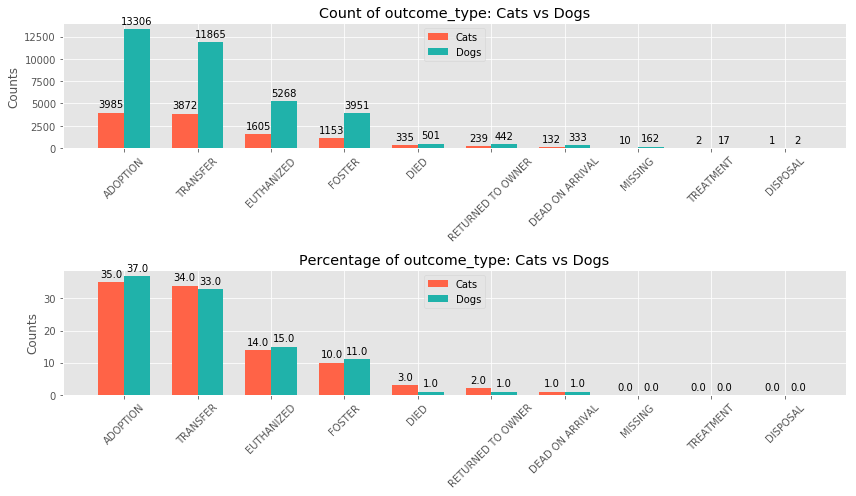

In [157]:
fig, axes = plt.subplots(2,1, figsize=(12,7))

bar_count(axes[0], cats['outcome_type'].value_counts(), dogs['outcome_type'].value_counts())
bar_percent(axes[1], cats['outcome_type'].value_counts(), dogs['outcome_type'].value_counts())

plt.tight_layout()

## Map